# 구현 초기 설정

In [1]:
# 패키지 import
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

C:\Users\tfg00\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tfg00\anaconda3\envs\pytorch\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


# 데이터셋 작성

In [2]:
# 입력 화상의 전처리 클래스
# 훈련 시와 추론 시 처리가 다르다.

class ImageTransform():
    """
    화상 전처리 클래스, 훈련 시, 검증 시의 동작이 다르다.
    화상 크기를 리사이즈하고 색상을 표준화한다.
    훈련 시에는 RandomResizedCrop과 RandomHorizentalFlip으로 데이터를 확장한다.
    
    Attributes
    ----------
    resize : int
        리사이즈 대상 화상의 크기
    mean : (R, G, B)
        각 색상 채널의 평균 값
    std : (R,G, B)
        각 색상 채널의 표준편차
    """
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                resize, scale = (0.5, 1.0)), # 데이터 확장
                transforms.RandomHorizontalFlip(), # 데이터 확장
                transforms.ToTensor(), # 텐서로 변환
                transforms.Normalize(mean, std) # 표준화
            ]),
            'val' : transforms.Compose([
                transforms.Resize(resize), # 리사이즈
                transforms.CenterCrop(resize), # 화상 중앙을 resize x resize로 자른다.
                transforms.ToTensor(), # 텐서로 변환
                transforms.Normalize(mean, std) # 표준화
            ])
            
        }
    
    def __call__(self, img, phase = 'train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 지정
        """
        return self.data_transform[phase](img)
    

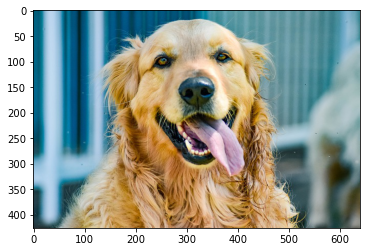

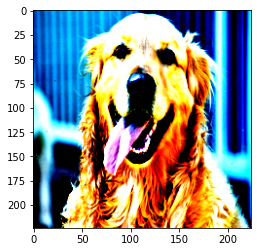

In [6]:
# 훈련 시 화상 전처리 동작 확인
# 실행할 때마다 처리 결과 화상이 바뀐다.

# 1. 화상 읽기
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) # [높이][폭][색RGB]

# 2. 원본 화상 표시
plt.imshow(img)
plt.show()

# 3. 화상 전처리, 처리된 화상 표시
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase = "train") # torch.Size([3, 224, 224])

# (색상, 높이, 너비)를 (높이, 너비, 색상)으로 변환하고 0~1로 값을 제한해 표시
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [9]:
# 데이터 파일 경로를 저장하는 리스트 변수 생성
def make_datapath_list(phase = "train"):
    """
    데이터의 경로를 저장한 리스트 작성
    
    Parameters
    ----------
    phase : 'train' or 'val'
        훈련 데이터 또는 검증 데이터 지정
    
    Returns
    ----------
    path_list : list
        데이터 경로를 저장한 리스트
    """
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath + phase + '/**/*.jpg')
    print(target_path)
    
    path_list = [] # 여기에 저장
    
    # glob을 이용하여 하위 디렉토리의 파일 경로를 가져온다.
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

# 실행
train_list = make_datapath_list(phase = "train")
val_list = make_datapath_list(phase = "val")

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train\\ants\\0013035.jpg',
 './data/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg',
 './data/hymenoptera_data/train\\ants\\1360291657_dc248c5eea.jpg',
 './data/hymenoptera_data/train\\ants\\1368913450_e146e2fb6d.jpg',
 './data/hymenoptera_data/train\\ants\\1473187633_63ccaacea6.jpg',
 './data/hymenoptera_data/train\\ants\\148715752_302c84f5a4.jpg',
 './data/hymenoptera_data/train\\ants\\1489674356_09d48dde0a.jpg',
 './data/hym

In [12]:
# 개미와 벌의 화상에 대한 Dataset 작성

class HymenopteraDataset(data.Dataset):
    """
    개미와 벌 화상의 Dataset 클래스. 파이토치의 Dataset 클래스 상속
    
    Attributes
    ----------
    file_list : 리스트
        화상 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'test'
        학습인지 훈련인지 설정
    """
    
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list # 파일 경로 리스트
        self.transform = transform # 전처리 클래스의 인스턴스
        self.phase = phase # train or val 지정
        
    def __len__(self):
        '''화상 개수를 반환'''
        return len(self.file_list)
    
    def __getitem__(self, index):
        '''
        전처리한 화상의 텐서 형식의 데이터와 라벨 취득
        '''
        
        # index번재의 화상 로드
        img_path = self.file_list[index]
        img = Image.open(img_path) # [높이][폭][색RGB]
        
        # 화상의 전처리 실시
        img_transformed = self.transform(
            img, self.phase) # torch.Size([3, 224, 224])
        
        # 화상 라벨을 파일 이름에서 추출
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]
            
        # 라벨을 숫자로 변경
        if label == 'ants':
            label = 0
        elif label == "bees":
            label = 1
        
        return img_transformed, label

# 실행
train_dataset = HymenopteraDataset(
    file_list = train_list, transform = ImageTransform(size, mean, std), phase = 'train')

val_dataset = HymenopteraDataset(
    file_list = val_list, transform = ImageTransform(size, mean, std), phase = 'val')

# 동작 확인
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


# 데이터 로더 작성

In [14]:
# 미니 배치 크기 지정
batch_size = 32

# 데이터 로더 작성
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = batch_size, shuffle = False)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"]) # 반복자(iterator)로 변환
inputs, labels = next(
    batch_iterator) # 첫 번째 요소 추출
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1])


# 네트워크 모델 작성

In [15]:
# 학습된 VGG - 16 모델 로드
# VGG-16 모델의 인스턴스 생성
use_pretrained = True # 학습된 파라미터 사용
net = models.vgg16(pretrained = use_pretrained)

# VGG16의 마지막 출력층의 출력 유닛을 개미와 벌인 두 개로 변경
net.classifier[6] = nn.Linear(in_features=4096, out_features = 2)

# 훈련 모드로 설정
net.train()

print("네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.")

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


# 손실함수 정의

In [16]:
# 손실 함수 설정
criterion = nn.CrossEntropyLoss()

# 최적화 기법 설정

In [18]:
# 전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장
params_to_update = []

# 학습 시킬 파라미터명
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 학습시킬 파라미터 외에는 경사를 계산하지 않고 변하지 않도록 설정
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False # True로 설정하면 오차 역전파로 경사를 계산하여 학습시에 값이 변함

# params_to_update의 내용 확인
print("--------------")
print(params_to_update)


classifier.6.weight
classifier.6.bias
--------------
[Parameter containing:
tensor([[ 0.0003, -0.0142,  0.0154,  ...,  0.0097,  0.0040,  0.0110],
        [-0.0065, -0.0104,  0.0063,  ...,  0.0031, -0.0010, -0.0089]],
       requires_grad=True), Parameter containing:
tensor([ 0.0033, -0.0101], requires_grad=True)]


In [19]:
# 최적화 기법 설정
optimizer = optim.SGD(params=params_to_update, lr = 0.001, momentum=0.9)

# 학습 및 검증 실시

In [29]:
# 모델을 학습시키는 함수 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    # 에포크 루프
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        # 에포크 별 학습 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 모델을 훈련 모드로
            else:
                net.eval() # 모델을 검증 모드로
            
            epoch_loss = 0.0 # 에포크 손실 합
            epoch_corrects = 0 # 에포크 정답 수
            
            # 학습하지 않을 시 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch == 0) and (phase == 'train'):
                continue
            
            # 데이터 로더로 미니 배치를 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                # 옵티마이저 초기화
                optimizer.zero_grad()
                
                # 순전파 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 손실 계산
                    _, preds = torch.max(outputs, 1) # 라벨 예측
                    
                    # 훈련 시에는 오차 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # 반복 결과 계산
                    # 손실 합계 갱신
                    epoch_loss += loss.item() * inputs.size(0)
                    # 정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds == labels.data)
                    
                    # 에포크당 손실과 정답률 표시
                    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
                    epoch_acc = epoch_corrects.double(
                    ) / len(dataloaders_dict[phase].dataset)
                    
                    print('{} Loss : {:.4f} Acc : {:.4f}'.format(
                        phase, epoch_loss, epoch_acc))

In [30]:
# 학습 및 검증 실시
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

Epoch 1/2
-------------


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

val Loss : 0.0412 Acc : 0.2026


 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

val Loss : 0.0433 Acc : 0.3987


 60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

val Loss : 0.0300 Acc : 0.6078


 80%|████████  | 4/5 [00:11<00:03,  3.03s/it]

val Loss : 0.0397 Acc : 0.8039


100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


val Loss : 0.0437 Acc : 0.9608
Epoch 2/2
-------------


 12%|█▎        | 1/8 [00:03<00:23,  3.41s/it]

train Loss : 0.0269 Acc : 0.1235


 25%|██▌       | 2/8 [00:06<00:21,  3.51s/it]

train Loss : 0.0328 Acc : 0.2387


 38%|███▊      | 3/8 [00:10<00:18,  3.64s/it]

train Loss : 0.0363 Acc : 0.3498


 50%|█████     | 4/8 [00:14<00:14,  3.55s/it]

train Loss : 0.0313 Acc : 0.4650


 62%|██████▎   | 5/8 [00:17<00:10,  3.56s/it]

train Loss : 0.0226 Acc : 0.5885


 75%|███████▌  | 6/8 [00:21<00:07,  3.57s/it]

train Loss : 0.0187 Acc : 0.7119


 88%|████████▊ | 7/8 [00:24<00:03,  3.55s/it]

train Loss : 0.0105 Acc : 0.8436


100%|██████████| 8/8 [00:27<00:00,  3.39s/it]


train Loss : 0.0059 Acc : 0.9218


 20%|██        | 1/5 [00:03<00:15,  3.77s/it]

val Loss : 0.0182 Acc : 0.2092


 40%|████      | 2/5 [00:07<00:11,  4.00s/it]

val Loss : 0.0317 Acc : 0.4052


 60%|██████    | 3/5 [00:11<00:07,  3.92s/it]

val Loss : 0.0133 Acc : 0.6078


 80%|████████  | 4/5 [00:15<00:03,  3.93s/it]

val Loss : 0.0262 Acc : 0.8039


100%|██████████| 5/5 [00:18<00:00,  3.73s/it]

val Loss : 0.0331 Acc : 0.9608
